# Build a Travily and Invoke Gen AI with Bedrock Chatbot

In this tutorial, you handle queries you chatbot can't answer "from memory", integrate a web search tool. The chatbot can use this tool to find relevant information and provide better responses.

In [11]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 5.6 MB/s eta 0:00:00


In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt langchain-tavily
# %pip install --quiet -U langchain_aws langchain_core langgraph langgraph-prebuilt langchain-tavily

In [38]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ["AWS_ACCESS_KEY_ID"] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ["AWS_SECRET_ACCESS_KEY"] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ["AWS_DEFAULT_REGION"] = userdata.get('AWS_DEFAULT_REGION')

#import os
#from google.colab import userdata
# os.environ["AWS_ACCESS_KEY_ID"] = userdata.get('AWS_ACCESS_KEY_ID')
# os.environ["AWS_SECRET_ACCESS_KEY"] = userdata.get('AWS_SECRET_ACCESS_KEY')
# os.environ["AWS_DEFAULT_REGION"] = userdata.get('AWS_DEFAULT_REGION')
# #os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [39]:
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "tutorial"

## Define the tool

Define the web search tool:

API Reference: [TavilySearch](https://python.langchain.com/api_reference/tavily/tavily_search/langchain_tavily.tavily_search.TavilySearch.html?_gl=1*tlbqc8*_gcl_au*MTk2MDM5MDU2Ny4xNzUwMjQ5NzE2*_ga*MTcwNDU4NTgyMS4xNzUwMjQ5NzE2*_ga_47WX3HKKY2*czE3NTA4NTQ2NjkkbzE0JGcxJHQxNzUwODU2MzgyJGo0MyRsMCRoMA..)

In [40]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(max_results=2)

# Define the tool use AWS API Gateway endpoint

In [41]:
from langchain_core.tools import tool
import requests
import json
import boto3
import time

@tool
def invoke_genai_api(prompt: str) -> str:
    """
    Calls API Gateway to trigger Step Function and returns GenAI result.
    """
    # API Gateway endpoint
    url = "https://krlrqdwise.execute-api.us-east-1.amazonaws.com/dev/invoke"
    region = "us-east-1"
    state_machine_arn = "arn:aws:states:us-east-1:058264295817:stateMachine:InvokeGenAIStateMachine"

    # Prepare payload
    headers = {
        "Content-Type": "application/json"
    }
    payload = {
        "input": json.dumps({"prompt": prompt}),
        "stateMachineArn": state_machine_arn
    }

    try:
        # Step 1: Start Step Function via API Gateway
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        response.raise_for_status()
        execution_arn = response.json().get("executionArn")

        if not execution_arn:
            return "Failed to get executionArn from API Gateway response."

        print(f"Execution started. ARN: {execution_arn}")

        # Step 2: Poll Step Functions for result
        client = boto3.client('stepfunctions', region_name=region)
        while True:
            exec_desc = client.describe_execution(executionArn=execution_arn)
            status = exec_desc["status"]

            if status == "RUNNING":
                print("Waiting for Step Function to complete...")
                time.sleep(2)
                continue
            elif status == "SUCCEEDED":
                break
            else:
                return f"Execution failed with status: {status}"

        # Step 3: Parse response to extract GenAI result
        outer_output = json.loads(exec_desc["output"])
        lambda_output = json.loads(outer_output["body"])
        return lambda_output

    except Exception as e:
        return f"Error during GenAI invocation: {str(e)}"

In [43]:
tools = [search_tool ,invoke_genai_api]
# search_tool .invoke("What's a 'node' in LangGraph?")
invoke_genai_api.invoke("What's a 'node' in LangGraph?")

Execution started. ARN: arn:aws:states:us-east-1:058264295817:execution:InvokeGenAIStateMachine:793c3e21-a71b-44bc-acbb-8e93c6e72e86
Waiting for Step Function to complete...
Waiting for Step Function to complete...
Waiting for Step Function to complete...


" LangGraph is not a recognized term in the context of programming, computer science, or graph theory. It seems like it might be a typo or a specific term used in a certain context that I'm not aware of.\n\nHowever, if you're referring to a 'node' in the context of graph theory or data structures, a node is a fundamental unit that represents data. It can be a connection point or a vertex in a graph. Each node may contain data and a link to other nodes.\n\nIf you're referring to Node.js, it's an open-source, cross-platform, JavaScript runtime environment that executes JavaScript code outside a web browser.\n\nIf you meant something else, could you please provide more context or check the term? I'd be happy to help further."

## Define the graph

For the StateGraph you created in the first tutorial, add bind_tools on the LLM. This lets the LLM know the correct JSON format to use if it wants to use the search engine.

> - use claude sonnet 3 model for function calling or model which supports function calling

In [44]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")


#from langchain_aws import ChatBedrock

#llm = ChatBedrock(
#    model_id="claude-3.5-sonnet-update this value from bedrock",
#    temperature=1,
#)

We can now incorporate it into a StateGraph:

In [45]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools,parallel_tool_calls=False)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the LLM's response messages to whatever messages are already in the state.

## Create a function to run the tools

Now, create a function to run the tools if they are called. Do this by adding the tools to a new node calledBasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

In [46]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        outputs = []
        for tool_call in message.tool_calls:
            tool_name = tool_call["name"]
            print(f"[INFO] Tool Invoked: {tool_name}")

            if tool_name not in self.tools_by_name:
                raise KeyError(f"Tool '{tool_name}' not found in tools list")

            tool_result = self.tools_by_name[tool_name].invoke(tool_call["args"])
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_name,
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

## Define the conditional_edges

With the tool node added, now you can define the conditional_edges.

Edges route the control flow from one node to the next. Conditional edges start from a single node and usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

Next, define a router function called route_tools that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to tools if tool calls are present and END if not. Because the condition can return END, you do not need to explicitly set a finish_point this time.

In [47]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

## Visualize the graph

You can visualize the graph using the get_graph method and one of the "draw" methods, like draw_ascii or draw_png. The draw methods each require additional dependencies.

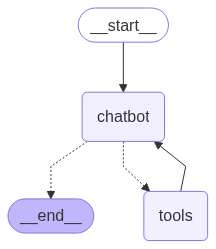

In [48]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Ask the bot questions

Now you can ask the chatbot questions outside its training data:

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            if "messages" in value:
                if value["messages"]:
                    print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Invoke Gen Api : what is langgraph
Assistant: 
[INFO] Tool Invoked: invoke_genai_api
Execution started. ARN: arn:aws:states:us-east-1:058264295817:execution:InvokeGenAIStateMachine:18404589-9478-4c28-ba1d-cfcad3857062
Waiting for Step Function to complete...
Waiting for Step Function to complete...
Assistant: " Langgraph is not a recognized term or a well-known entity in the fields of technology, linguistics, or academia. It is possible that it may be a typo, or it might refer to a specific project or concept that is not widely known or used.\n\nIf you meant \"language graph,\" it could refer to a graphical representation or visualization of languages and their relationships, such as a language family tree or a network diagram showing the connections between different languages.\n\nIf you meant something else, could you please provide more context or information so that I can better understand and provide a helpful response?"
Assistant: Langgraph is not a recognized term or well-